<a href="https://colab.research.google.com/github/MinsooKwak/study/blob/main/Faster_RCNN/Faster_RCNN_pytorch_notebook_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install torch==1.1.0
# !pip install pycocotools==2.0
# !pip install opencv_python==4.1.0.25
# !pip install numpy==1.16.4
# !pip install torchvision==0.3.0
# !pip install Pillow==6.1.0
# !pip install vision==0.0.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
cd /content/drive/MyDrive/Colab_Notebooks/FasterRCNN/Faster-RCNN-with-torchvision-master/

/content/drive/.shortcut-targets-by-id/1_X03zL_I3ldO2dc7nhpT6-ZOeOWVIOsl/FasterRCNN/Faster-RCNN-with-torchvision-master


In [4]:
import torch
import torchvision  # torch들을 사용해 모델들을 불러옴
import cv2          # 이미지 visualize 하는데 사용 예정
import numpy as np
import sys
sys.path.append('./')
import coco_names   # coco에 class와 실제 이름을 연결시켜주는 내용
import random
from google.colab.patches import cv2_imshow   # colab에서 영상으로 opencv를 보여주기 위한 함수


In [5]:
# 하이퍼파라미터도 정의함
model_path = './result/model_19.pth'  # 학습한 모델의 결과 폴더의 19번째 모델을 불러오겠다
image_path='./imgs/2.jpg'
model_name ='fasterrcnn_resnet50_fpn' # fasterrcnn에 backbone을 resnet50을 사용하고 fpn을 추가 사용하겠다
dataset_name ='coco'
score_threshold = 0.8

In [6]:
def random_color():
    '''
    박스칠때 random한 color로 visualize 하기 위해 함수 정의
    '''
    b = random.randint(0,255)
    g = random.randint(0,255)
    r = random.randint(0,255)

    return (b,g,r)

In [7]:
def main():
    input = []
    if dataset_name == 'coco':
        num_classes = 91
        names = coco_names.names  #coco_names.py에서 names 딕셔너리를 불러왔음
        
    # Model creating
    print("Creating model")
    # torchvision에서 간단한 함수로 호출해서 불러와 사용
    # torchvision.models.detection 모델을 사용할 것이고, model_name을 적어주면 원하는 모델을 불러올 수 있음
    model = torchvision.models.detection.__dict__[model_name](num_classes=num_classes, pretrained=True)  
    model = model.cuda()  #gpu를 사용할 것이기 때문에 모델을 gpu에 올려줌

    model.eval()  #gradient를 남기지 않겠다

    # save = torch.load(model_path)
    # model.load_state_dict(save['model'])

    # h, w, c
    src_img = cv2.imread(image_path)  #이미지 불러오기

    # BGR to RGB (opencv는 BGR로 불러오기 때문에 RGB로 변경)
    img = cv2.cvtColor(src_img,cv2.COLOR_BGR2RGB)

    # scale 0~1 (/255), shape c,h,w(permutation함수 이용해 바꿔줬음) 
    # 두번째 demension을 0번째로 가져오겠다, 0번째 demension을 첫번째 demension으로, 첫번쨰 demension을 두번쨰 demension으로 보겠다
    # unit8로 정의되어 있는 함수여서 float로 변경해줌
    # opencv로 불러올 떄 numpy로 되어 있기 떄문에 torch tensor로 바꾸기 위해 torch.from_numpy()
    img_tensor = torch.from_numpy(img/255.).permute(2,0,1).float().cuda() 
    input.append(img_tensor)  #input list에 img_tensor append
    
    #1,c,h,w
    out = model(input)          # model에 input을 넣으면 3개의 out
    boxes = out[0]['boxes']     # box당 4개의 coordinate(box의 좌표)
                                # faster rcnn에서는 box당 k개의 anchor box가 정해져 있었음
                                # boxes의 개수 == window개수 * anchor의 개수
    labels = out[0]['labels']   # RPN 통과 후 proposal에서 region proposal에 대한 값으로 coordinates, score (box를 어디에 칠지, object 있는지 없는지)
                                # classifier를 통과하면 최종적으로 나오는 값 # box가 어떤 물체인지
    scores = out[0]['scores']   # 2가지 score (object인지 아닌지에 대한 확률값(object 있는 것 | object 없는 것)-> softmax-> 있는 쪽의 확률값 알게 됨)

    # box의 수들을 for문을 돌릴 것
    for idx in range(boxes.shape[0]):
        if scores[idx] >= score_threshold:  # softmax 취했을 때 확률값이 threshold 이상인 box에 대해서만 실제 box 치겠다
            #x1, y1 왼쪽 상단 # x2, y2 오른쪽 하단
            x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
            name = names.get(str(labels[idx].item())) # 0~90까지의 숫자를 갖는 label이 나올텐데 idx에서 names의 dictionary에서 실제 글자를 뽑아오는 함수
            # cv2.rectangle(img,(x1,y1),(x2,y2),colors[labels[idx].item()],thickness=2)
            print(src_img.shape, x1,y1,x2,y2) # 실제 영상의 이미지, 박스 위치를 print
            cv2.rectangle(src_img,(int(x1),int(y1)),(int(x2),int(y2)),random_color(),thickness=2) # box 시각화 
            cv2.putText(src_img, text=name, org=(int(x1), int(y1)+10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=0.5, thickness=1, lineType=cv2.LINE_AA, color=(0, 0, 255))


    cv2_imshow(src_img)
    # cv2.imwrite('assets/11.jpg',img)

Creating model


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(333, 500, 3) tensor(245.4672, device='cuda:0', grad_fn=<SelectBackward0>) tensor(50.3707, device='cuda:0', grad_fn=<SelectBackward0>) tensor(316.2784, device='cuda:0', grad_fn=<SelectBackward0>) tensor(157.0618, device='cuda:0', grad_fn=<SelectBackward0>)
(333, 500, 3) tensor(74.1687, device='cuda:0', grad_fn=<SelectBackward0>) tensor(19.5567, device='cuda:0', grad_fn=<SelectBackward0>) tensor(144.9687, device='cuda:0', grad_fn=<SelectBackward0>) tensor(161.8655, device='cuda:0', grad_fn=<SelectBackward0>)
(333, 500, 3) tensor(16.6159, device='cuda:0', grad_fn=<SelectBackward0>) tensor(24.7124, device='cuda:0', grad_fn=<SelectBackward0>) tensor(486.5868, device='cuda:0', grad_fn=<SelectBackward0>) tensor(330.4807, device='cuda:0', grad_fn=<SelectBackward0>)
(333, 500, 3) tensor(4.0995, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0., device='cuda:0', grad_fn=<SelectBackward0>) tensor(80.9728, device='cuda:0', grad_fn=<SelectBackward0>) tensor(128.1900, device='cuda:0', grad_fn=<

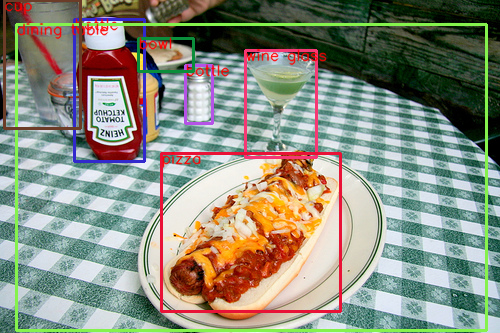

In [8]:
main()